# Enron Scandal: The smartest guys in the room?

## Author: Sagarnil Das
## Date: 28th June, 2017

Enron, a multibillion dollar company in the heart of the Wall Street was one of the largest companies in the United States in 2000. By 2002, it collapsed into bankruptcy due to widespread corporate fraud. They reached a dizzying height only to face a plummeting collapse. The bankruptcy of Enron affected thousands of its employees and shook the whole Wall Street by its foundation. In the federal investigation that followed, all the emails from Enron employees were made public. Since then these emails have spreaded like a wildfire through the world and many analysis and investigations have been done on this data. In this project, my target is to build a ** Person of Interest ** identifier/Label and try to build a Machine Learning Algorithm to predict the possible Persons of Interest based on various features.

## Summarize the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?

The goal of this project was to utilize the financial and email data from Enron to build a predictive, analytic model that could identify whether an individual could be considered a "person of interest" (POI). Since the dataset contained labeled data--culpable persons were already listed as POIs--the value of this model on the existing dataset is limited. Rather, the potential value such a model may provide is in application to other datasets from other companies, to potentially identify suspects worth investigating further. The dataset contained 146 records with 14 financial features, 6 email features, and 1 labeled feature (POI). Of the 146 records, 18 were labeled, a priori, as persons of interest. Through exploratory data analysis and cursory spreadsheet/CSV review, I was able to identify 2 candidate records for removal:

TOTAL: This was an extreme outlier for most numerical features, as it was likely a spreadsheet artifact.
THE TRAVEL AGENCY IN THE PARK: This record did not represent an individual.
After data cleaning, 144 records remained.

## Initial Preparation/Importing Libraries

In [503]:
import matplotlib.pyplot as plt
import sys
import pickle
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from time import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.grid_search import GridSearchCV
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import pprint
import warnings
warnings.filterwarnings('ignore')

## Create Features list and Import necessary files

In [504]:
features_list = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments',
                 'loan_advances', 'bonus', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person',
                 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

## Initial data exploration

In [505]:
#Sample data for one of the Top executives - Jeffrey Skilling
pprint.pprint(data_dict["SKILLING JEFFREY K"])

#Number of people in the datasets

print "Total number of people in the dataset: " + str(len(data_dict))

#Number of features available in the dataset

print "Total number of features in the dataset: " + str(len(data_dict["SKILLING JEFFREY K"]))

#Number of POIs in the dataset

def poi_count(file):
    count = 0
    for data in file:
        if file[data]['poi'] == True:
            count += 1
    print "Number of POIs in the dataset: " + str(count)

poi_count(data_dict)


{'bonus': 5600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'jeff.skilling@enron.com',
 'exercised_stock_options': 19250000,
 'expenses': 29336,
 'from_messages': 108,
 'from_poi_to_this_person': 88,
 'from_this_person_to_poi': 30,
 'loan_advances': 'NaN',
 'long_term_incentive': 1920000,
 'other': 22122,
 'poi': True,
 'restricted_stock': 6843672,
 'restricted_stock_deferred': 'NaN',
 'salary': 1111258,
 'shared_receipt_with_poi': 2042,
 'to_messages': 3627,
 'total_payments': 8682716,
 'total_stock_value': 26093672}
Total number of people in the dataset: 146
Total number of features in the dataset: 21
Number of POIs in the dataset: 18


## Detect outliers and remove them

Now we will consider a few features where having outliers can significantly affect our whole analysis. We will analyze these outliers to see whether they should be there or we can remove them to make our analysis more robust.

97343619.0


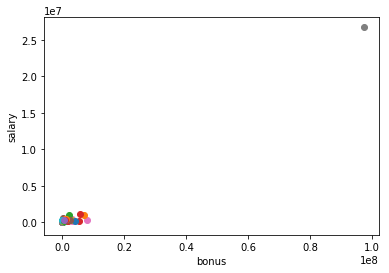

In [506]:
features = ["bonus","salary"]
data = featureFormat(data_dict, features)
print(data.max())

for point in data:
    bonus = point[0]
    salary = point[1]
    plt.scatter( bonus, salary )

plt.xlabel("bonus")
plt.ylabel("salary")
plt.show()

WOW! That's a huge outlier right there in the upper right corner! In fact it is so big that it is making all the other points insignificant in scale. So what's going on over there? Looking at the dataset, we see it is an excel artifact which calculated the ** TOTAL ** value or the sum. So it should be removed. Another point which should be removed is ** THE TRAVEL AGENCY IN THE PARK **. Both of these values does not belong to any individual and thus not significant for our analysis. We also try to find out who got the maximum salary and the maximum bonus.

## Maximum Salary

In [507]:
outliers_salary = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers_salary.append((key,int(val)))

pprint.pprint(sorted(outliers_salary,key=lambda x:x[1],reverse=True)[:2])

[('TOTAL', 26704229), ('SKILLING JEFFREY K', 1111258)]


## Maximum Bonus

In [508]:
from pprint import pprint
outliers_bonus = []
for key in data_dict:
    val = data_dict[key]['bonus']
    if val == 'NaN':
        continue
    outliers_bonus.append((key,int(val)))

pprint(sorted(outliers_bonus,key=lambda x:x[1],reverse=True)[:2])

[('TOTAL', 97343619), ('LAVORATO JOHN J', 8000000)]


Thats's some insane amount of money right there!

## Removing Total and Travel Agency in the Park outliers

In [509]:
data_dict.pop('TOTAL',0)
data_dict.pop('THE TRAVEL AGENCY IN THE PARK',0)

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

## Plotting after outlier removal

We will try to plot the same plot. Now that we have removed the huge outliers, we should expect to see something much different than what we saw before.


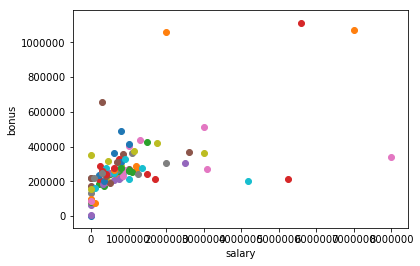

In [510]:
my_dataset = data_dict
my_feature_list = features_list
data = featureFormat(data_dict, features)
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )


plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

## Investigating emails from and to a Person of Interest

Now we will investigate from_this_person_to_poi and from_poi_to_this_person for any outliers as they are important features

609.0


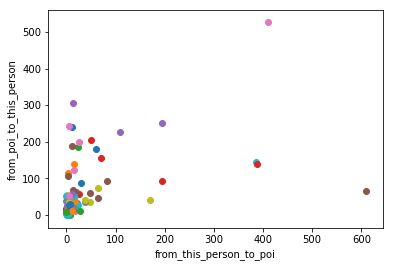

In [511]:
features = ["from_this_person_to_poi", "from_poi_to_this_person"]
data = featureFormat(data_dict, features)

print data.max()
#Plotting the graph
for point in data:
    from_this_person_to_poi = point[0]
    from_poi_to_this_person = point[1]
    plt.scatter( from_this_person_to_poi, from_poi_to_this_person )

plt.xlabel("from_this_person_to_poi")
plt.ylabel("from_poi_to_this_person")
plt.show()


Here we see a few outliers. But on investigation, I found out that they are real persons and not data error. So I am going to keep them in the dataset

## Dealing with 'NaN' values

In [512]:
#Making dataframes in pandas one for the keys and one for the values

df_values = pd.DataFrame.from_records(list(data_dict.values()))
df_values.head()

df_persons = pd.Series(list(data_dict.keys()))
df_persons.head()

#We see lot's of NaN values. So we have to take care of that. We will convert them to numpy nan and then to zero.
df_values.replace(to_replace='NaN', value=np.nan, inplace=True)

# Count number of NaN's for columns
print df_values.isnull().sum()

# DataFrame dimension
print df_values.shape


df_null = df_values.replace(to_replace=np.nan, value=0)
df_null = df_values.fillna(0).copy(deep=True)
df_null.columns = list(df_values.columns.values)
print df_null.isnull().sum()
print df_null.head()

df_null.describe()


bonus                         63
deferral_payments            106
deferred_income               96
director_fees                128
email_address                 33
exercised_stock_options       43
expenses                      50
from_messages                 58
from_poi_to_this_person       58
from_this_person_to_poi       58
loan_advances                141
long_term_incentive           79
other                         53
poi                            0
restricted_stock              35
restricted_stock_deferred    127
salary                        50
shared_receipt_with_poi       58
to_messages                   58
total_payments                21
total_stock_value             19
dtype: int64
(144, 21)
bonus                        0
deferral_payments            0
deferred_income              0
director_fees                0
email_address                0
exercised_stock_options      0
expenses                     0
from_messages                0
from_poi_to_this_person      0
from_

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,1.440000e+02,144.000000,144.000000,144.000000,144.000000,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,144.000000,1.440000e+02,1.440000e+02
mean,6.759974e+05,2.220896e+05,-1.936833e+05,9980.319444,2.075802e+06,35375.340278,363.583333,38.756944,24.625000,5.828125e+05,3.369578e+05,2.947455e+05,8.685363e+05,7.341790e+04,1.854460e+05,702.611111,1238.555556,2.256543e+06,2.909786e+06
std,1.233155e+06,7.541013e+05,6.060111e+05,31300.575144,4.795513e+06,45309.303038,1450.675239,74.276769,79.778266,6.794472e+06,6.871826e+05,1.131325e+06,2.016572e+06,1.301983e+06,1.970421e+05,1077.290736,2237.564816,8.847189e+06,6.189018e+06
min,0.000000e+00,-1.025000e+05,-3.504386e+06,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-2.604490e+06,-1.787380e+06,0.000000e+00,0.000000,0.000000,0.000000e+00,-4.409300e+04
25%,0.000000e+00,0.000000e+00,-3.708600e+04,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.434500e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,9.019275e+04,2.443265e+05
50%,3.000000e+05,0.000000e+00,0.000000e+00,0.000000,6.082935e+05,20182.000000,17.500000,4.000000,0.000000,0.000000e+00,0.000000e+00,9.190000e+02,3.605280e+05,0.000000e+00,2.105960e+05,114.000000,347.500000,9.413595e+05,9.659550e+05
75%,8.000000e+05,8.535500e+03,0.000000e+00,0.000000,1.683580e+06,53328.250000,53.000000,41.250000,14.000000,0.000000e+00,3.745862e+05,1.485770e+05,7.374560e+05,0.000000e+00,2.696675e+05,933.750000,1623.000000,1.945668e+06,2.295176e+06
max,8.000000e+06,6.426990e+06,0.000000e+00,137864.000000,3.434838e+07,228763.000000,14368.000000,528.000000,609.000000,8.152500e+07,5.145434e+06,1.035973e+07,1.476169e+07,1.545629e+07,1.111258e+06,5521.000000,15149.000000,1.035598e+08,4.911008e+07


## Feature selection

For selecting the best features I am going to use SelectKBest method from scikit-learn. And then, I would use recursive feature selection to find a good indication of the number of relevant features and how the cross validation score varies with the increase in number of features. But before using SelectKBest, I am going to perform a few tasks. First of all I am just going to see the accuracy, precision score and the recall score of the features as they exist now using Decision Tree. The selection of Decision tree is not random. As I have already gone through one cycle, I know that Decision tree will be one of the best algorithms for fitting my model. Then I am going to perform feature engineering and create some new features and add them to the features list and take the accuracy, precision score and the recall score of the features list with these new features added to see the difference between the old features list and this new features list after newly added features. After that I plan to make it a half manual iterative process. That is, add all possible best features and then remove them one by one using the score values and human intuition. So in essence this will be a cyclic process. The recursive feature selection will help us big time to find a optimum K value to increase our model efficiency. Before building the classifier, I will also scale all features using a min-max scaler. This was vitally important, as the features had different units (e.g. # of email messages and USD) and varied significantly by several orders of magnitude.

## Classifier's Result before Feature Engineering

In [513]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)
features_train,features_test,labels_train,labels_test = cross_validation.train_test_split(features,labels, test_size=0.3, 
                                                                                          random_state=42)
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("Decision Tree Classifier: ")
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))

Decision Tree Classifier: 
Accuracy: 0.837209302326
Precision Score: 0.0
Recall Score: 0.0


So we see before any feature engineering, our Decision Tree classifier is giving us an accuracy of 83.72% with Precision score and Recall Scores of 0.25 and 0.2 respectively

## Feature Engineering

Now let's add some new features of interest to the list of the features. I will make a function to do that. 

In [514]:
def add_poi_ratio(data_dict, features_list):
    """ mutates data dict to add proportion of email interaction with pois """
    fields = ['to_messages', 'from_messages',
              'from_poi_to_this_person', 'from_this_person_to_poi']
    for record in data_dict:
        person = data_dict[record]
        is_valid = True
        for field in fields:
            if person[field] == 'NaN':
                is_valid = False
        if is_valid:
            total_messages = person['to_messages'] +\
                             person['from_messages']
            poi_messages = person['from_poi_to_this_person'] +\
                           person['from_this_person_to_poi']
            person['poi_ratio'] = float(poi_messages) / total_messages
        else:
            person['poi_ratio'] = 'NaN'
    features_list += ['poi_ratio']



def add_fraction_to_poi(data_dict, features_list):
    """ mutates data dict to add proportion of email fraction_to_poi """
    fields = ['from_messages', 'from_this_person_to_poi']
    for record in data_dict:
        person = data_dict[record]
        is_valid = True
        for field in fields:
            if person[field] == 'NaN':
                is_valid = False
        if is_valid:
            total_messages = person['from_messages']
            poi_messages =   person['from_this_person_to_poi']
            person['fraction_to_poi'] = float(poi_messages) / total_messages
        else:
            person['fraction_to_poi'] = 'NaN'
    features_list += ['fraction_to_poi']


def add_fraction_from_poi(data_dict, features_list):
    """ mutates data dict to add proportion of email fraction_from_poi """
    fields = ['to_messages', 'from_poi_to_this_person']
    for record in data_dict:
        person = data_dict[record]
        is_valid = True
        for field in fields:
            if person[field] == 'NaN':
                is_valid = False
        if is_valid:
            total_messages = person['to_messages']
            poi_messages =   person['from_poi_to_this_person']
            person['fraction_from_poi'] = float(poi_messages) / total_messages
        else:
            person['fraction_from_poi'] = 'NaN'
    features_list += ['fraction_from_poi']



#Adding them to the features list
add_poi_ratio(data_dict, my_feature_list)
add_fraction_to_poi(data_dict, my_feature_list)
add_fraction_from_poi(data_dict, my_feature_list)
print my_feature_list

['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees', 'poi_ratio', 'fraction_to_poi', 'fraction_from_poi']


## Classifier's Result after Feature Engineering

In [515]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)
features_train,features_test,labels_train,labels_test = cross_validation.train_test_split(features,labels, test_size=0.3, 
                                                                                          random_state=42)
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("Decision Tree Classifier: ")
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))

Decision Tree Classifier: 
Accuracy: 0.860465116279
Precision Score: 0.333333333333
Recall Score: 0.2


So we see after the feature engineering of three new features, our Decision Tree classifier is giving us an accuracy of 86.04% with both precision score and recall score of 0.400.

So now I will use SelectKBest algorithm to rank the features in order to find the most effective features. First I put all the possible features into features_list and then started deleting them one by one using score value and human intuition. I started with all features initially. But when I ran the recursive feature selection to find a good indication of the number of relevant features and how the cross validation score varies with the increase in number of features, I saw that there was a peak at around 7. So in this 2nd cycle, we will use a value of 7 for k.

In [516]:
def get_k_best(enron_data, features_list, k):
    """ runs scikit-learn's SelectKBest feature selection
        returns dict where keys=features, values=scores
    """
    data = featureFormat(data_dict, features_list)
    labels, features = targetFeatureSplit(data)

    k_best = SelectKBest(k=k)
    k_best.fit(features, labels)
    scores = k_best.scores_
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    k_best_features = dict(sorted_pairs[:k])
    print "{0} best features: {1}\n".format(k, k_best_features.keys())
    print k_best_features
    return k_best_features

target_label = 'poi'
num_features = 7 # 11 best features
top_features = get_k_best(data_dict, features_list, num_features)
print top_features
my_feature_list = [target_label] + top_features.keys()
# print my_feature_list

print "{0} selected features: {1}\n".format(len(my_feature_list) - 1, my_feature_list[1:])

features_list = my_feature_list

7 best features: ['salary', 'bonus', 'total_stock_value', 'fraction_to_poi', 'exercised_stock_options', 'deferred_income', 'long_term_incentive']

{'salary': 18.289684043404513, 'bonus': 20.792252047181535, 'total_stock_value': 24.182898678566879, 'fraction_to_poi': 16.409712548035799, 'exercised_stock_options': 24.815079733218194, 'deferred_income': 11.458476579280369, 'long_term_incentive': 9.9221860131898225}
{'salary': 18.289684043404513, 'bonus': 20.792252047181535, 'total_stock_value': 24.182898678566879, 'fraction_to_poi': 16.409712548035799, 'exercised_stock_options': 24.815079733218194, 'deferred_income': 11.458476579280369, 'long_term_incentive': 9.9221860131898225}
7 selected features: ['salary', 'bonus', 'total_stock_value', 'fraction_to_poi', 'exercised_stock_options', 'deferred_income', 'long_term_incentive']



## Validity of SelectKBest

Using these sets of features gave me an accuracy of around 71.43% in the first cycle, and the precision and the recall score remained very low(0.2 and 0.333 respectively) which are the more vital metrices for this specific project even more than the accuracy. This is because in this specific dataset, only 18 POIs are present. Originally there were 35 POIs. But for some reason half of them is not present in this dataset. So accuracy cannot be depended on very much for this dataset and thus we have to depend heavily on the precision and the recall score.

So after much manual intervention and going back and forth, I selected the following features to be the final features as these are informations directly related to the POIs and hence not very open to interpretation even to machines. So a high value of fraction_from_poi may indicate that the person receiving those emails may be a POI himself or even in the executive board. Same logic goes for fraction_to_poi and shared_receipt_with_poi. These features were not selected at random but after extensive manual testing.

1. fraction_from_poi
2. fraction_to_poi
3. shared_receipt_with_poi

In [517]:
features_list = ["poi", "fraction_from_poi", "fraction_to_poi", "shared_receipt_with_poi"]

## What features did I end up using in your POI identifier, and what selection process did I use to pick them? Did I have to do any scaling? Why or why not?

In this project, first I used scikit-learn's SelectKBest module to get the 7 best features among the 21 features present. This was because in the recursive feature selection, I saw a peak at around 7 for the features vs cross validation score. But this had to be a half manual iterative process as the dataset is very skewed towards non POIs and only 18 POIs were there in the dataset. So when I was using the 7 features suggested by SelectKBest algorithm, I was getting an accuracy of only ~72% with very low precision and recall score (0.2 and 0.333 respectively). In the below table you can see the top 7 features along with their scores. The K-best approach is an automated univariate feature selection algorithm, and in using it, I was concerned with the lack of email features in the resulting dataset. Thus, I engineered three features, poi_ratio, fraction_to_poi and fraction_from_poi which were the proportion of email interaction with POIs, proportion of email fraction to POIs and proportion of email fraction from POIs. So here we mutate our original data dictionary and add these new features to the features' list. The scores of the 7 best features selected by K-best approach is given below. Apart from these 7 features, I also added 3 more features regarding emails: ** 'poi_ratio', 'fraction_to_poi' and 'fraction_from_poi' ** .

1. exercised_stock_options: 24.815079733218194
2. total_stock_value: 24.182898678566879
3. bonus: 20.792252047181535
4. salary: 18.289684043404513
5. fraction_to_poi: 16.409712548035799
6. deferred_income: 11.458476579280369
7. long_term_incentive: 9.9221860131898225

After much iterative manual testing with different combinations of the features and trying out by deleting them one at a time, I finally came up with these 4 features to be used as my final features list:

** 1. ** fraction_from_poi

** 2. ** fraction_to_poi

** 3. ** shared_receipt_with_poi


Before training the machine learning algorithm classifiers, I scaled all features using a min-max scaler. This was vitally important, as the features had different units and varied significantly by several orders of magnitude. Feature-scaling ensured that for the applicable classifiers, the features would be weighted evenly. Only after this step, I split my data into training and testing set.

## Extract features and labels from dataset for local testing

In [518]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

## Scaling the features by MinMaxScaler from Sklearn preprocessing module

In [519]:
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

## Splitting the data into train data(70%) and test data(30%)

In [520]:
features_train,features_test,labels_train,labels_test = cross_validation.train_test_split(features,labels, test_size=0.3, 
                                                                                          random_state=42)

## Using different Machine Learning Classifiers

We will iterate through variety of classifiers to see which one's prediction is the best.

## Decision Tree Classifier

In [521]:
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("Decision Tree Classifier: ")
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))

Decision Tree Classifier: 
Accuracy: 0.961538461538
Precision Score: 1.0
Recall Score: 0.5


## Naive Bayes Classifier

In [522]:
clf = GaussianNB()
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("Naive Bayes Classifier: ")
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))

Naive Bayes Classifier: 
Accuracy: 0.923076923077
Precision Score: 0.0
Recall Score: 0.0


## AdaBoost Classifier

In [523]:
clf = AdaBoostClassifier()
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("Adaboost Classifier: ")
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))

Adaboost Classifier: 
Accuracy: 0.961538461538
Precision Score: 1.0
Recall Score: 0.5


## Standard Vector Machine (rbf) Classifier

In [524]:
clf = SVC(gamma=3, C=2)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("SVM Classifier: ")
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))

SVM Classifier: 
Accuracy: 0.923076923077
Precision Score: 0.0
Recall Score: 0.0


## K Nearest Neighbours Classifier

In [525]:
clf = KNeighborsClassifier(3)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("kNN Classifier: ")
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))

kNN Classifier: 
Accuracy: 0.846153846154
Precision Score: 0.0
Recall Score: 0.0


## What algorithm did I end up using? What other one(s) did I try? How did model performance differ between algorithms?

I used Decision Tree Classifier to predict the possible POIs in the dataset. The main motivation for me behind using this classifier was that the Nonlinear relationships between parameters do not affect tree performance and Decision trees implicitly perform variable screening or feature selection. I also noticed that this was one of the classifiers which was giving one of the highest accuracies. Apart from Decision trees, I also tried fitting the train data and predict the test data with Naive Bayes, Adaboost, K Nearest Neighbours and Standard Vector Machine classifiers. Adaboost gave almost as high precision metrices as decision trees. Naive Bayes and SVM also gave higher accuracy scores around 92-93% but the precision and the recall score of SVM was zero. With Decision trees, at this point I was getting an accuracy score around 96.15% with a precision score of 1 and recall score of 0.500. Given below are the precision metrices for all the algorithms I tried.

** 1. Decision Tree **
 
 a) Accuracy - 96.153%
  
 b) Precision Score - 1
  
 c) Recall Score - 0.500
  
   
** 2. Naive Bayes **

 a) Accuracy: 92.31%
  
 b) Precision Score: 0
  
 c) Recall Score: 0
 
** 4. Adaboost **

 a) Accuracy: 96.153%
 
 b) Precision Score: 1
 
 c) Recall Score: 0.5
 
** 5. Standard Vector Machine **

 a) Accuracy: 92.31%
 
 b) Precision Score: 0
 
 c) Recall Score: 0
 
** 6. K nearest neighbours **

 a) Accuracy: 84.62%
 
 b) Precision Score: 0
 
 c) Recall Score: 0

## What does it mean to tune the parameters of an algorithm, and what can happen if I don’t do this well?  How did I tune the parameters of your particular algorithm? What parameters did I tune?

Parameter tuning for any algorithm in Machine Learning is a vital step. Our goal, is usually to set the parameters for the algorithm used to get optimal values that enable us to complete a learning task in the best way possible. Thus, tuning an algorithm or machine learning technique, can be simply thought of as process which one goes through in which they optimize the parameters that impact the model in order to enable the algorithm to perform the best (once, of course we have defined what "best" actual is).

With our dataset accuracy is not quite meaningful because of the disproportion among classes. So here, we are more interested in the precision score and the recall score metrices. Before tuning my algorithm, the values precision score was 1 and the recall score was 0.500 with an accuracy of 96.15%. Maybe this high value was caused by some overfitting. I tuned my Decision Tree Classifier model with GridSearchCV and validated the using Stratified Shuffle Split and Cross Validation with my customized scoring function to put a threshold for both precision_score and the recall_score. The parameters which I tuned were max_depth, min_samples_split, min_samples_leaf and criterion. The final accuracy I got after tuning my model ranged between 87-89% with a precision score around 0.433 and the recall score of 0.822.

In [526]:
from sklearn import grid_search
from sklearn.metrics import f1_score

In [527]:
cv = cross_validation.StratifiedShuffleSplit(labels, n_iter=10)


def scoring(estimator, features_test, labels_test):
    labels_pred = estimator.predict(features_test)
    p = precision_score(labels_test, labels_pred, average='micro')
    r = recall_score(labels_test, labels_pred, average='micro')
    if p > 0.3 and r > 0.3:
        return f1_score(labels_test, labels_pred, average='macro')
    return 0


## Recursive Feature Selection

Optimal number of features : 3
[ True  True  True]


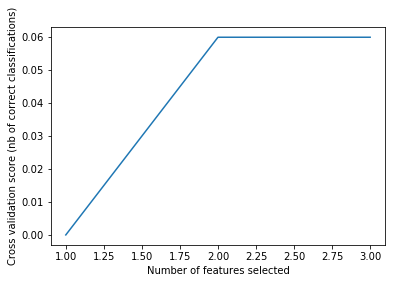

In [528]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
clf = DecisionTreeClassifier(max_depth = 5)
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(labels, 50),
          scoring='precision')
rfecv.fit(features, labels)
print("Optimal number of features : %d" % rfecv.n_features_)
print rfecv.support_
features=features[:,rfecv.support_]
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## Decision Tree Classifier Tuning

In [534]:
t0 = time()
parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 8, 9, 10], 'min_samples_split':[2,3,4,5,6,7,8,9,10],
              'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8], 'criterion': ('gini', 'entropy')}

decTree_clf = DecisionTreeClassifier()
decTreeclf = grid_search.GridSearchCV(decTree_clf, parameters, scoring=scoring, cv=cv)

decTreeclf.fit(features, labels)
print decTreeclf.best_estimator_
print decTreeclf.best_score_
print 'Processing time:', round(time() - t0, 3), 's'

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.887857142857
Processing time: 112.183 s


## What is validation, and what’s a classic mistake you can make if I do it wrong? How did I validate my analysis?

In machine learning, model validation is referred to as the process where a trained model is evaluated with a testing data set. The testing data set is a separate portion of the same data set from which the training set is derived. The main purpose of using the testing data set is to test the generalization ability of a trained model. Validation is performed to ensure that a machine learning algorithm generalizes well. A classic mistake is over-fitting, where the model is trained and performs very well on the training dataset, but markedly worse on the cross-validation and test datasets. I utilized two methods for validating the analysis:

1. ** StratifiedShuffleSplit, folds = 1000 : ** The main reason why I used Startified Shuffle Split as a validation method was that the dataset was small and skewed towards non-POI. I needed a technique that accounts for that. Otherwise the risk is that in the validation phase, we would not be able to assess the real potential of our algorithm in terms of performance metrics. The chance of randomly splitting skewed and non representative validation sub-sets could be high, therefore the need to use stratification (preservation of the percentage of samples for each class) to achieve robustness in a dataset with the aforementioned limitations. I took the average precision an recall score of 1000 randomized trials with the help of test_classifier function. This data was subset into training and testing set in a 3:1 ratio.

2. ** Cross Validation: ** Cross Validation is a technique which involves reserving a particular sample of a data set on which you do not train the model. Later, you test the model on this sample before finalizing the model. Here I did a cross validation on the data by splitting the data, fitting a model and computing the score 5 consecutive times (with different splits each time). I used 'accuracy' as a scorer object.

## Classifier Validation

In [535]:
##DecisionTreeClassifier Validation 1 (StratifiedShuffleSplit, folds = 1000)
from tester import test_classifier
t0 = time()
decTree_best_clf = decTreeclf.best_estimator_
test_classifier(decTree_best_clf, my_dataset, features_list)
print 'Processing time:', round(time() - t0, 3), 's'

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.86056	Precision: 0.43286	Recall: 0.82200	F1: 0.56709	F2: 0.69673
	Total predictions: 9000	True positives:  822	False positives: 1077	False negatives:  178	True negatives: 6923

Processing time: 2.276 s


In [536]:
##DecisionTreeClassifier Validation 2  (Cross validation)

from sklearn.model_selection import cross_val_score
t0 = time()
decTree_best_clf = decTreeclf.best_estimator_
scores = cross_val_score(decTree_best_clf, features, labels, cv=5,scoring = 'accuracy')
print("Accuracy and Deviation: " + str((scores.mean(), scores.std() * 2)))
print 'Processing time:', round(time() - t0, 3), 's'
test_classifier(decTree_best_clf, my_dataset, features_list)

Accuracy and Deviation: (0.84738562091503267, 0.10525920072782949)
Processing time: 0.052 s
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.86056	Precision: 0.43286	Recall: 0.82200	F1: 0.56709	F2: 0.69673
	Total predictions: 9000	True positives:  822	False positives: 1077	False negatives:  178	True negatives: 6923



## Give at least 2 evaluation metrics and the average performance for each of them.  Explain an interpretation of my metrics that says something human-understandable about my algorithm’s performance.

The main evaluation metrics utilized were precision and recall. Precision captures the ratio of true positives to the records that are actually POIs, essentially describing how often 'false alarms' are (not) raised. Recall captures the ratio of true positives to the records flagged as POIs, which describes sensitivity. For the Decision tree algorithm which I used, following were the evaluation metrices for the two validations:

** 1. StratifiedShuffleSplit **

 a) Precision: 0.50829	
 
 b) Recall: 0.82200
   
** 2. Cross Validation **

 a) Precision: 0.50292
 
 b) Recall: 0.82200

Both validations performed quite well given the fact that this dataset didn't contain plethora of data (very few POIs) and the data was noisy too. The recall score is very high. This is actually a good thing. The ratio of the false positives to true positives is much higher than the ratio of false negatives to true negatives. This is actually good for us because we would rather mark a person as POI who in reality is not a POI than not able to catch the Real POIs and marking them as False POIs. My argument here is even though we mark someone as a POI wrongly, he/she will still get through unscathed after investigation. But on the other hand, if we miss someone who is indeed guilty, then that person is just not facing the justice as he/she should have.

## Conclusion

So we see by applying Stratified Shuffle Split to our Decision Tree Classifier, we are able to improve the performance metrices of our classifier. This dataset is a very sparse dataset where accuracy(almost 89% in our case) is not a good metrics given the fact it is very skewed towards non POIs. We only have 18 POIs in the dataset. Even though originally we had 36 POIs, somehow half of them are not present in this dataset. We have a high recall score(0.822) which is a good thing given how sparse this dataset is and where accuracy is not a good metrics to perform model quality. We also see that ratio of the false positives to true positives is much higher than the ratio of false negatives to true negatives. This is actually good for us because we would rather mark a person as POI who in reality is not a POI than not able to catch the Real POIs and marking them as False POIs. My argument here is even though we mark someone as a POI wrongly, he/she will still get through unscathed after investigation. But on the other hand, if we miss someone who is indeed guilty, then that person is just not facing the justice as he/she should have. 

These numbers are quite good but still we can improve the accuracy of the model. One of the possible ways is to dig into the actual email messages more. Then we can find a pattern of emails to/from a specific point instead of to/from POIs. We can also do text mining to make some vocabulary pattern emerge from this huge chunks of emails to get more behavioural patterns of the POIs. As we found out that the POI data was incomplete in our dataset, the next realistic thing to try might be to extract more data from the emails.